In [2]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')

GPU0 Memory: 1499MB


Exception: GPU Memory too low

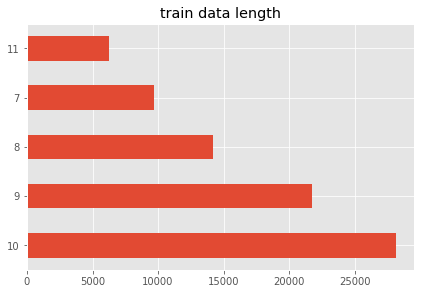

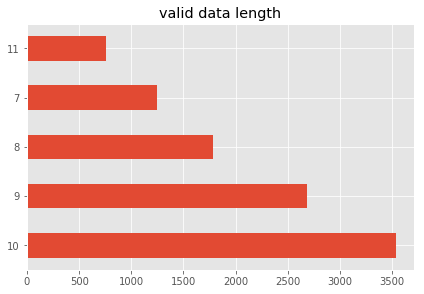

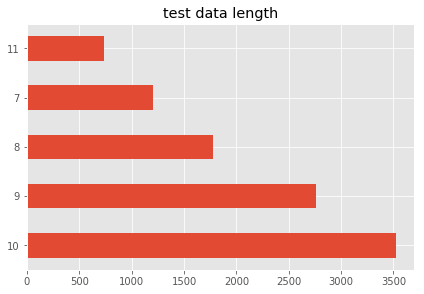

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 统计字符长度
def draw_hist(data, title):
    plt.style.use(u'ggplot')
    fig = pd.DataFrame(data, index=[0]).transpose()[0].plot(kind='barh')
    fig = fig.get_figure()
    fig.tight_layout()
    plt.title(title)
    plt.show()

data_csv = pd.read_csv('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)
list_length_train = list()
for str in y_train:
    list_length_train.append(len(str))
list_length_train = pd.Series(list_length_train).value_counts().to_dict()
draw_hist(list_length_train, 'train data length')

list_length_valid = list()
for str in y_valid:
    list_length_valid.append(len(str))
list_length_valid = pd.Series(list_length_valid).value_counts().to_dict()
draw_hist(list_length_valid,'valid data length')

list_length_test = list()
for str in y_test:
    list_length_test.append(len(str))
list_length_test = pd.Series(list_length_test).value_counts().to_dict()
draw_hist(list_length_test,'test data length')


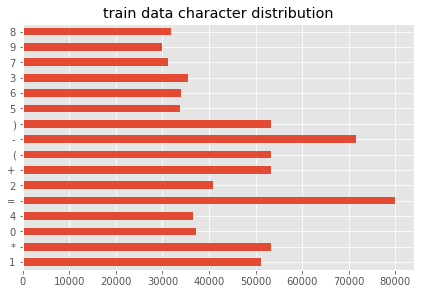

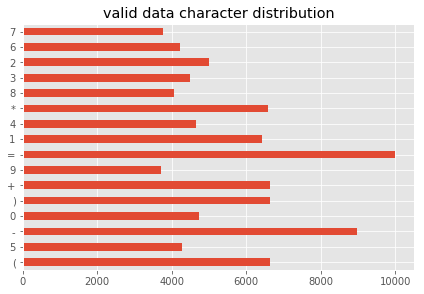

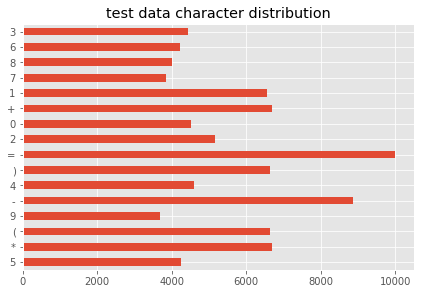

In [3]:
# 统计字符分布
from collections import defaultdict
sum_character_train = defaultdict(int)
for str in y_train:
    for character in str:
        sum_character_train[character] += 1
sum_character_train = dict(sum_character_train)
draw_hist(sum_character_train,'train data character distribution')

sum_character_valid = defaultdict(int)
for str in y_valid:
    for character in str:
        sum_character_valid[character] += 1
sum_character_valid = dict(sum_character_valid)
draw_hist(sum_character_valid,'valid data character distribution')

sum_character_test = defaultdict(int)
for str in y_test:
    for character in str:
        sum_character_test[character] += 1
sum_character_test = dict(sum_character_test)
draw_hist(sum_character_test,'test data character distribution')

In [4]:
# 所有待识别字符
CHAR_VECTOR = "0123456789+-*()=a"
letters = [letter for letter in CHAR_VECTOR]

In [5]:
# 将索引转换为字符
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))
# 将字符转换为索引
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [36]:
import cv2
import random
from tqdm import tqdm

class TextImageGenerator:
    def __init__(self, rootpath, img_dirpath, label, img_w, img_h, batch_size, downsample_factor, max_text_len):
        self.rootpath = rootpath # 文件根目录
        self.img_dirpath = img_dirpath
        self.label = label
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.n = len(self.img_dirpath) # 图片数量
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []

    def build_data(self):
        for i, img_file in enumerate(tqdm(self.img_dirpath)):
            img = cv2.imread(self.rootpath + img_file, cv2.IMREAD_GRAYSCALE)
#             print(self.rootpath + img_file)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            self.imgs[i, :, :] = img
            self.texts.append(self.label[i])
        print(self.n, " Image Loading finish...")

    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.empty([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                labels = text_to_labels(text)
                Y_data[i, 0:len(labels)] = labels
                Y_data[i, len(labels):13] = 16
                label_length[i] = len(text)

            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [7]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [8]:
from keras.layers import *
from keras.models import *

def get_model(img_w, img_h, num_classes, training):
    input_shape = (img_w, img_h, 1)  # (128, 64, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32') # (None, 128, 64, 1)

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)
    inner = Dropout(0.2)(inner)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)
    inner = Dropout(0.2)(inner)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)
    inner = Dropout(0.2)(inner)

#     inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
#     inner = BatchNormalization()(inner)
#     inner = Activation('relu')(inner)
#     inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
#     inner = BatchNormalization()(inner)
#     inner = Activation('relu')(inner)
#     inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)
#     inner = Dropout(0.2)(inner)

    inner = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    lstm_1 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    lstm1_merged = add([lstm_1, lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    lstm_2 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    lstm2_merged = concatenate([lstm_2, lstm_2b])  # (None, 32, 1024)
    lstm2_merged = Dropout(0.2)(lstm2_merged)
#     lstm_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal', name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') # (None ,8)
    input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
    label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

In [9]:
# 绘制准确率
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig("Training and validation accuracy.png")
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig("Training and validation loss.png")
    plt.show()

...New weight data...


  0%|                                                                                        | 0/80000 [00:00<?, ?it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18734.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97068.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56294.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38634.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52

  0%|                                                                              | 83/80000 [00:00<01:36, 823.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42542.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37891.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33357.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73

  0%|▏                                                                            | 180/80000 [00:00<01:32, 858.99it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50921.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44055.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8775.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3956

  0%|▎                                                                            | 274/80000 [00:00<01:30, 879.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83671.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42849.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37176.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93173.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/788

  0%|▎                                                                            | 366/80000 [00:00<01:29, 889.72it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13042.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52334.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58129.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22852.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36652.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26941.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81

  1%|▍                                                                            | 456/80000 [00:00<01:29, 890.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78918.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50556.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23601.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58117.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75060.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86

  1%|▌                                                                            | 545/80000 [00:00<01:29, 888.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47868.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2065.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64950.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76785.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35730.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32291.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36752.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20788.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/670

  1%|▌                                                                            | 636/80000 [00:00<01:29, 890.40it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13108.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19139.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/540.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22146.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91084.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68650.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45219.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1739.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72672

  1%|▋                                                                            | 725/80000 [00:00<01:29, 888.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42864.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73733.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38414.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84205.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79100.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30797.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57393.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32

  1%|▊                                                                            | 814/80000 [00:00<01:29, 884.26it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35770.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83479.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82082.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72984.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48418.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/610

  1%|▊                                                                            | 905/80000 [00:01<01:28, 889.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55999.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98344.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81286.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15005.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/278

  1%|▉                                                                            | 997/80000 [00:01<01:28, 896.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37857.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66040.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11043.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3656.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45699.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71567.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/362

  1%|█                                                                           | 1089/80000 [00:01<01:27, 901.65it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16770.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13555.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68055.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61272.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29618.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67

  1%|█                                                                           | 1182/80000 [00:01<01:26, 908.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68784.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70682.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3007.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10832.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85989.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38045.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/837

  2%|█▏                                                                          | 1276/80000 [00:01<01:25, 915.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31710.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7649.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77116.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/602

  2%|█▎                                                                          | 1368/80000 [00:01<01:26, 912.11it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34120.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86448.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67846.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6995.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93631.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/965

  2%|█▍                                                                          | 1459/80000 [00:01<01:26, 906.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5295.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52022.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48388.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31931.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2780.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54471

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78167.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51160.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47741.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77

  4%|██▋                                                                         | 2809/80000 [00:03<01:19, 969.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3374.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26850.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/565

  4%|██▊                                                                         | 2907/80000 [00:03<01:20, 961.75it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90829.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91070.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79031.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93248.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58572.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19533.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83683.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

  4%|██▊                                                                         | 3010/80000 [00:03<01:18, 979.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36169.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61664.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61187.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17641.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23445.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28

  4%|██▉                                                                         | 3109/80000 [00:03<01:19, 966.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18842.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62058.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6806.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60341.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25951.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59186.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/653

  4%|███                                                                         | 3206/80000 [00:03<01:20, 953.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87822.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65667.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49269.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82038.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82252.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67

  4%|███▏                                                                        | 3302/80000 [00:03<01:20, 953.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3446.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2108.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30480.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57248.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6549

  4%|███▏                                                                        | 3399/80000 [00:03<01:20, 956.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49373.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32040.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46788.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57

  4%|███▎                                                                        | 3495/80000 [00:03<01:20, 946.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38398.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40718.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66253.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85636.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90689.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17

  4%|███▍                                                                        | 3590/80000 [00:03<01:21, 937.38it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85605.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7301.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45361.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5921.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12501.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9007

  5%|███▍                                                                        | 3684/80000 [00:03<01:21, 933.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64656.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23905.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9101

  5%|███▌                                                                        | 3778/80000 [00:04<01:21, 933.29it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61495.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17254.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82263.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10328.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56597.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29806.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38

  5%|███▋                                                                        | 3872/80000 [00:04<01:23, 908.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90074.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38352.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71964.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81236.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29356.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47

  5%|███▊                                                                        | 3966/80000 [00:04<01:22, 916.09it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32588.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12020.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13694.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49025.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33568.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68467.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55

  5%|███▊                                                                        | 4062/80000 [00:04<01:22, 924.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62770.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59684.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30031.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43447.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78796.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/654

  5%|███▉                                                                        | 4157/80000 [00:04<01:21, 927.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86031.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93837.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84267.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27602.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53777.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31707.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11381.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54944.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3479.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56016.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/757

  7%|█████▏                                                                     | 5525/80000 [00:05<01:14, 1001.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23610.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51418.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51506.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56532.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77104.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64485.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95

  7%|█████▎                                                                     | 5626/80000 [00:06<01:14, 1002.17it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54549.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90588.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16707.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90

  7%|█████▍                                                                      | 5727/80000 [00:06<01:14, 999.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67992.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70887.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99425.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80602.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30925.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69544.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32

  7%|█████▍                                                                     | 5828/80000 [00:06<01:14, 1000.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57953.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11728.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67315.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/959

  7%|█████▌                                                                     | 5933/80000 [00:06<01:13, 1012.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1378.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92267.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71009.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61488.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/653

  8%|█████▋                                                                     | 6035/80000 [00:06<01:13, 1012.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51362.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17560.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71071.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64944.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34475.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17702.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57

  8%|█████▊                                                                     | 6140/80000 [00:06<01:12, 1021.36it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2921.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87124.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12773.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13875.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5384

  8%|█████▊                                                                     | 6243/80000 [00:06<01:12, 1018.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14559.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7736.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38553.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1276

  8%|█████▉                                                                     | 6346/80000 [00:06<01:12, 1019.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48912.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3343.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38066.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69005.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1902

  8%|██████                                                                     | 6449/80000 [00:06<01:12, 1011.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56641.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7004.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24616.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82168.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96722.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74843.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/572

  8%|██████▏                                                                     | 6551/80000 [00:06<01:14, 985.62it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/423.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55562.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61497.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28516.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84226.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15600.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86136.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6914

  8%|██████▎                                                                     | 6650/80000 [00:07<01:15, 976.06it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60681.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19913.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70898.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26177.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46454.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10048.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69

  8%|██████▍                                                                     | 6748/80000 [00:07<01:15, 969.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18951.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92005.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29086.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74397.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94561.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40

  9%|██████▌                                                                     | 6846/80000 [00:07<01:16, 958.99it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55644.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21616.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8766.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42672.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3268

  9%|██████▌                                                                     | 6943/80000 [00:07<01:17, 943.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66121.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18317.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10566.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73462.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24813.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40342.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61830.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37211.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47070.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9

 10%|███████▉                                                                    | 8375/80000 [00:08<01:15, 947.18it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10559.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29756.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58244.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64465.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/352

 11%|████████                                                                    | 8476/80000 [00:08<01:14, 963.17it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91066.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20929.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69640.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33030.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39344.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79

 11%|████████▏                                                                   | 8577/80000 [00:09<01:13, 974.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74263.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14617.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22805.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60676.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88433.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/356

 11%|████████▏                                                                   | 8680/80000 [00:09<01:12, 988.54it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13104.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43921.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52736.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41715.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92655.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7343

 11%|████████▎                                                                   | 8780/80000 [00:09<01:11, 989.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60651.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43597.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19431.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19608.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7070.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39606.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8371

 11%|████████▍                                                                   | 8881/80000 [00:09<01:11, 993.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64838.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24143.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61637.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17978.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66852.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93138.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69823.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29728.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56

 11%|████████▍                                                                  | 8986/80000 [00:09<01:10, 1007.75it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84645.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63219.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65925.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98927.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34

 11%|████████▌                                                                  | 9087/80000 [00:09<01:10, 1006.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42434.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81063.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26175.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75069.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/519

 11%|████████▌                                                                  | 9189/80000 [00:09<01:10, 1008.15it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40273.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88833.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95927.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78892.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5374

 12%|████████▋                                                                  | 9290/80000 [00:09<01:10, 1006.50it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11971.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99053.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78480.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68460.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10329.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59653.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83866.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86

 12%|████████▊                                                                  | 9392/80000 [00:09<01:10, 1008.32it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4258.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68706.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71551.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8811

 12%|████████▉                                                                  | 9494/80000 [00:09<01:09, 1009.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4879.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23637.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76406.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/534

 12%|████████▉                                                                  | 9595/80000 [00:10<01:09, 1007.51it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48392.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26998.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46842.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95284.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20812.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19

 12%|█████████                                                                  | 9698/80000 [00:10<01:09, 1011.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13488.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7097.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43364.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29813.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97310.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7883

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57718.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89330.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89736.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30294.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9

 14%|██████████▎                                                                | 11032/80000 [00:11<01:14, 929.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28961.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13900.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5711.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31735.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/336

 14%|██████████▍                                                                | 11126/80000 [00:11<01:14, 930.39it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3777.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3327.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13297.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50694.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57181.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1443

 14%|██████████▌                                                                | 11222/80000 [00:11<01:13, 937.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42825.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84327.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96161.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15180.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9338.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18794.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/652

 14%|██████████▌                                                                | 11316/80000 [00:11<01:13, 933.12it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68167.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28906.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34532.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/648.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18809.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1359

 14%|██████████▋                                                                | 11410/80000 [00:12<01:14, 916.80it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32629.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84088.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36275.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28463.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35794.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42762.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96839.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73

 14%|██████████▊                                                                | 11503/80000 [00:12<01:14, 918.73it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76775.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55792.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73951.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96147.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80389.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69187.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15

 14%|██████████▊                                                                | 11595/80000 [00:12<01:15, 911.66it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26507.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7006.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64885.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74278.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15084.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/903

 15%|██████████▉                                                                | 11687/80000 [00:12<01:16, 898.83it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55341.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32240.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54568.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14706.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34

 15%|███████████                                                                | 11781/80000 [00:12<01:15, 908.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33390.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97516.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28701.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67617.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28140.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97108.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79

 15%|███████████▏                                                               | 11880/80000 [00:12<01:13, 929.86it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31538.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46269.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15978.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73215.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26145.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15

 15%|███████████▏                                                               | 11980/80000 [00:12<01:11, 947.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80667.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45511.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17102.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51278.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55235.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74981.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/102

 15%|███████████▎                                                               | 12080/80000 [00:12<01:10, 960.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93767.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86685.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42243.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46525.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/682

 15%|███████████▍                                                               | 12182/80000 [00:12<01:09, 975.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17181.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33328.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39743.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23

 15%|███████████▌                                                               | 12284/80000 [00:12<01:08, 986.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68332.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22137.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18639.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62784.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18003.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87236.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22

 15%|███████████▌                                                               | 12383/80000 [00:13<01:09, 968.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3125.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84500.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81777.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31137.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84815.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22501.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/452

 16%|███████████▋                                                               | 12481/80000 [00:13<01:10, 963.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94067.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43308.jpg

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62484.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90239.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55510.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6775.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59

 17%|████████████▉                                                              | 13826/80000 [00:14<01:12, 909.13it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80492.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68638.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23857.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99299.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93

 17%|█████████████                                                              | 13918/80000 [00:14<01:12, 910.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34971.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62880.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47588.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82608.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42251.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/273

 18%|█████████████▏                                                             | 14010/80000 [00:14<01:12, 905.92it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8144.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73055.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59771.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/283

 18%|█████████████▏                                                             | 14103/80000 [00:14<01:12, 911.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73122.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87610.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9081.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33808.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77664.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64487.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/705

 18%|█████████████▍                                                             | 14286/80000 [00:15<01:12, 907.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67445.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13059.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38381.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57008.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54

 18%|█████████████▍                                                             | 14383/80000 [00:15<01:11, 920.73it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63398.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8992.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53869.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28205.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/994

 18%|█████████████▌                                                             | 14476/80000 [00:15<01:11, 910.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78858.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85175.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64610.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98622.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62

 18%|█████████████▋                                                             | 14568/80000 [00:15<01:11, 908.78it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20742.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90465.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14504.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30701.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75286.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31836.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88

 18%|█████████████▋                                                             | 14660/80000 [00:15<01:12, 907.45it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81468.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52531.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15869.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30122.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18558.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70263.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83167.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84381.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97

 18%|█████████████▊                                                             | 14754/80000 [00:15<01:11, 912.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61190.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50570.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28364.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43527.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6324.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/573

 19%|██████████████                                                             | 14944/80000 [00:15<01:10, 927.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57238.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56088.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13981.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91087.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86278.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8937.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/100

 19%|██████████████                                                             | 15038/80000 [00:15<01:09, 929.52it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35757.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68776.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45850.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16312.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32422.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41641.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/136

 19%|██████████████▏                                                            | 15134/80000 [00:16<01:09, 936.46it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44852.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93566.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16280.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52978.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56490.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57

 19%|██████████████▎                                                            | 15238/80000 [00:16<01:07, 963.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10065.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32875.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33627.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91757.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25298.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85

 19%|██████████████▍                                                            | 15342/80000 [00:16<01:05, 983.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54765.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40554.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29217.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63576.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/124

 19%|██████████████▍                                                            | 15441/80000 [00:16<01:05, 983.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9535.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29092.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85086.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31489.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/264

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44860.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54662.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32752.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21932.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74510.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24

 21%|███████████████▉                                                           | 16966/80000 [00:17<01:09, 906.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17748.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45337.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43660.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90792.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75217.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42

 21%|███████████████▉                                                           | 17062/80000 [00:18<01:08, 920.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78722.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27538.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98611.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22821.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65421.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1722.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/349

 21%|████████████████                                                           | 17155/80000 [00:18<01:08, 918.25it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47966.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/708.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19119.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11735.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20521.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8683.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60797.

 22%|████████████████▏                                                          | 17247/80000 [00:18<01:08, 914.05it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40512.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48190.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17236.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54166.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33227.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88460.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28

 22%|████████████████▎                                                          | 17431/80000 [00:18<01:08, 910.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31189.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41950.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13547.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27766.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/682.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41236

 22%|████████████████▍                                                          | 17527/80000 [00:18<01:07, 923.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69193.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70496.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25254.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26543.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69102.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2753.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/694

 22%|████████████████▌                                                          | 17622/80000 [00:18<01:07, 929.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22113.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46264.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94334.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98560.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83186.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84858.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85275.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96

 22%|████████████████▌                                                          | 17715/80000 [00:18<01:07, 927.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97513.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22227.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60670.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15581.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48249.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29710.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70

 22%|████████████████▋                                                          | 17808/80000 [00:18<01:07, 923.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27141.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80175.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87713.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44632.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85720.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72016.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65

 22%|████████████████▊                                                          | 17901/80000 [00:18<01:07, 920.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70576.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25157.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76047.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45137.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73796.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84074.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18

 23%|████████████████▉                                                          | 18099/80000 [00:19<01:04, 954.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40107.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47294.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63802.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/543

 23%|█████████████████                                                          | 18208/80000 [00:19<01:02, 989.61it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66537.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30720.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47506.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23729.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61820.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54

 23%|████████████████▉                                                         | 18316/80000 [00:19<01:00, 1013.01it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79998.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21830.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91262.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29321.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56

 23%|█████████████████                                                         | 18428/80000 [00:19<00:59, 1040.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5272.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71880.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51402.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/189

 23%|█████████████████▏                                                        | 18639/80000 [00:19<00:58, 1040.22it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8085.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88453.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17773.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3301.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85858.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94975.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8741

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82049.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4293.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47839.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84976.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83288.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43675.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9927

 25%|██████████████████▊                                                        | 20024/80000 [00:21<01:02, 953.54it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37330.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75071.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95396.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64231.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63

 25%|██████████████████▊                                                        | 20120/80000 [00:21<01:03, 936.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43255.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98355.jpgG:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66327.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/542.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16920.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92318.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92342.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8200.

 25%|██████████████████▉                                                        | 20214/80000 [00:21<01:04, 924.62it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/136.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98828.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59001.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61043.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60362.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8852

 25%|███████████████████                                                        | 20307/80000 [00:21<01:04, 918.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/246.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54171.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16490.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93041.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12089.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34392.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7446

 26%|███████████████████▍                                                       | 20775/80000 [00:21<01:04, 918.17it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31556.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24076.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84041.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/976

 26%|███████████████████▌                                                       | 20871/80000 [00:21<01:03, 928.36it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95541.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85

 26%|███████████████████▋                                                       | 20966/80000 [00:22<01:03, 932.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91883.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81702.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97818.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12542.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23895.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35

 26%|███████████████████▋                                                       | 21060/80000 [00:22<01:05, 903.36it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66726.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84806.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30390.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66051.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75501.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/864

 26%|███████████████████▊                                                       | 21151/80000 [00:22<01:05, 903.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5819.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28739.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32379.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23078.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98423.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/128

 27%|███████████████████▉                                                       | 21243/80000 [00:22<01:04, 906.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16888.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34819.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2999.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53031.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47147.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/562

 27%|████████████████████                                                       | 21434/80000 [00:22<01:03, 928.94it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45458.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48174.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74147.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37

 27%|████████████████████▏                                                      | 21533/80000 [00:22<01:01, 944.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30189.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41087.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/194.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8407.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98014.

 27%|████████████████████▎                                                      | 21631/80000 [00:22<01:01, 952.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43295.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94727.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79045.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90108.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12999.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

 27%|████████████████████▎                                                      | 21727/80000 [00:22<01:01, 952.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10833.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41035.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16801.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49236.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4878.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76895.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88632.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/782

 27%|████████████████████▍                                                      | 21824/80000 [00:22<01:00, 955.92it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90635.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27172.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66097.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98219.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32002.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/465

 27%|████████████████████▌                                                      | 21923/80000 [00:23<01:00, 963.79it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90918.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9157.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42221.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68942.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3066

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96715.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79309.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84546.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72109.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80417.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65688.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1

 29%|█████████████████████▊                                                     | 23252/80000 [00:24<01:03, 889.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58676.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89196.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58412.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85112.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29185.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17612.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/323

 29%|█████████████████████▉                                                     | 23344/80000 [00:24<01:03, 896.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57195.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84139.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54002.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32053.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69526.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2656.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/137

 29%|█████████████████████▉                                                     | 23434/80000 [00:24<01:03, 892.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37323.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36655.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55

 29%|██████████████████████                                                     | 23527/80000 [00:24<01:02, 901.80it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97908.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44849.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97798.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13701.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50

 30%|██████████████████████▏                                                    | 23619/80000 [00:24<01:02, 905.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76634.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42018.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2110.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11540.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2269

 30%|██████████████████████▍                                                    | 23984/80000 [00:25<01:02, 892.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74416.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71728.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75789.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67925.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48933.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2093

 30%|██████████████████████▌                                                    | 24080/80000 [00:25<01:01, 909.73it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51123.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72807.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47842.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93941.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1454

 30%|██████████████████████▋                                                    | 24174/80000 [00:25<01:01, 913.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11247.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88773.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27819.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4898.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97224.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/982

 30%|██████████████████████▋                                                    | 24266/80000 [00:25<01:01, 905.70it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19073.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65732.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95876.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7682.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2815.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9808

 30%|██████████████████████▊                                                    | 24357/80000 [00:25<01:02, 894.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86443.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3090.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57241.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32358.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20327.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55018.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2856.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12545.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3775

 31%|███████████████████████                                                    | 24537/80000 [00:25<01:02, 881.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55558.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50565.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73023.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69849.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5863.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83759.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78083.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/581

 31%|███████████████████████                                                    | 24633/80000 [00:26<01:01, 901.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40225.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6933.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99953.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83062.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/899

 31%|███████████████████████▏                                                   | 24733/80000 [00:26<00:59, 927.30it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97401.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41123.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28003.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51461.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89343.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33513.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

 31%|███████████████████████▎                                                   | 24831/80000 [00:26<00:58, 940.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23359.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25913.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9166.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7532

 31%|███████████████████████▎                                                   | 24932/80000 [00:26<00:57, 958.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94689.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70905.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96361.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83107.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68761.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31

 31%|███████████████████████▌                                                   | 25127/80000 [00:26<00:57, 959.93it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50350.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40088.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67560.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/926

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62498.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64951.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26035.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63873.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57617.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25776.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14

 33%|████████████████████████▉                                                  | 26607/80000 [00:28<00:59, 900.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10584.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27406.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99348.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36748.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45

 33%|█████████████████████████                                                  | 26702/80000 [00:28<00:58, 912.94it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10231.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43291.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40130.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78627.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47337.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63204.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41141.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46918.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93

 33%|█████████████████████████                                                  | 26794/80000 [00:28<00:58, 905.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18862.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30393.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16378.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/907

 34%|█████████████████████████▏                                                 | 26885/80000 [00:28<00:58, 904.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27523.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79856.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68012.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38489.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61317.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50210.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30

 34%|█████████████████████████▎                                                 | 26980/80000 [00:28<00:57, 915.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53133.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99368.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34511.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35253.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8460.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53367.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/717

 34%|█████████████████████████▍                                                 | 27072/80000 [00:28<00:57, 915.04it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/288.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31955.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98345.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92145.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77179.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88873.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6371

 34%|█████████████████████████▍                                                 | 27164/80000 [00:28<00:58, 906.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72262.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47752.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62166.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/362.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75428.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32398.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91392.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6321

 34%|█████████████████████████▌                                                 | 27255/80000 [00:28<00:58, 897.51it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67367.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61068.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2035.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53417.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/111

 34%|█████████████████████████▋                                                 | 27345/80000 [00:28<00:58, 896.29it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16350.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49641.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80594.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40702.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99097.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3272.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/514

 34%|█████████████████████████▋                                                 | 27437/80000 [00:29<00:58, 901.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36397.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36466.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75328.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31805.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30561.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18595.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/573

 35%|██████████████████████████                                                 | 27802/80000 [00:29<00:58, 898.54it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56669.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44228.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34754.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40293.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4053

 35%|██████████████████████████▏                                                | 27899/80000 [00:29<00:56, 916.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24024.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84802.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69857.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11606.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89815.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12914.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97

 35%|██████████████████████████▏                                                | 27996/80000 [00:29<00:55, 930.26it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86349.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45763.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24415.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8151.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7295

 35%|██████████████████████████▎                                                | 28090/80000 [00:29<00:55, 931.13it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78192.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57823.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68823.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17101.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94

 35%|██████████████████████████▍                                                | 28184/80000 [00:29<00:55, 928.99it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61965.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57039.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55640.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97052.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77

 35%|██████████████████████████▌                                                | 28277/80000 [00:29<00:55, 927.27it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97140.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87456.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39254.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30238.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36779.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37685.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66572.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60421.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43485.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32345.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69

 37%|███████████████████████████▊                                               | 29692/80000 [00:31<00:57, 872.71it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52968.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16640.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80312.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56596.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22879.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79736.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8663

 37%|███████████████████████████▉                                               | 29785/80000 [00:31<00:56, 884.75it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7376.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60487.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79697.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53372.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45984.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/368

 37%|████████████████████████████                                               | 29882/80000 [00:31<00:55, 906.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2352.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49607.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87338.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15936.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/173

 37%|████████████████████████████                                               | 29976/80000 [00:31<00:54, 914.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90089.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92769.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80318.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16504.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6378.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67341.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36784.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/101

 38%|████████████████████████████▏                                              | 30068/80000 [00:31<00:55, 900.82it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57385.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40858.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11093.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75053.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82186.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

 38%|████████████████████████████▎                                              | 30159/80000 [00:32<00:55, 901.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66028.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63850.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8588.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/896

 38%|████████████████████████████▎                                              | 30250/80000 [00:32<00:55, 896.82it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69521.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50368.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91367.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15851.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56727.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73

 38%|████████████████████████████▍                                              | 30340/80000 [00:32<00:55, 887.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74133.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16011.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11872.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40390.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97

 38%|████████████████████████████▌                                              | 30429/80000 [00:32<00:55, 886.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31151.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62186.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42731.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42439.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56880.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/670

 38%|████████████████████████████▌                                              | 30520/80000 [00:32<00:55, 891.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88109.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25388.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34060.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88345.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43

 38%|████████████████████████████▋                                              | 30611/80000 [00:32<00:55, 895.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19358.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11220.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10961.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75076.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/188

 38%|████████████████████████████▊                                              | 30702/80000 [00:32<00:54, 897.52it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80553.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76490.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47172.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3192.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80840.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/978

 38%|████████████████████████████▊                                              | 30792/80000 [00:32<00:54, 896.28it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34602.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39834.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17293.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44530.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51329.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51

 39%|████████████████████████████▉                                              | 30882/80000 [00:32<00:54, 895.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7961.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66538.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56694.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93164.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33087.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/324

 39%|█████████████████████████████                                              | 30972/80000 [00:32<00:54, 894.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41144.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6495.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33672.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22964.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/619

 39%|█████████████████████████████                                              | 31066/80000 [00:33<00:54, 906.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83956.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6840.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20318.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36737.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73324.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/806

 39%|█████████████████████████████▏                                             | 31158/80000 [00:33<00:53, 908.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54766.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/652

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64397.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31531.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99628.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58

 41%|██████████████████████████████▊                                            | 32878/80000 [00:34<00:52, 904.79it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35063.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74532.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28092.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/736

 41%|██████████████████████████████▉                                            | 32969/80000 [00:35<00:52, 899.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62180.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58154.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68121.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67369.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80196.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40112.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25

 41%|██████████████████████████████▉                                            | 33059/80000 [00:35<00:52, 894.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17626.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14104.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38840.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39294.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32618.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20

 42%|███████████████████████████████▏                                           | 33241/80000 [00:35<00:52, 898.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14308.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37600.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39409.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95748.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69970.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54707.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28

 42%|███████████████████████████████▎                                           | 33334/80000 [00:35<00:51, 905.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/467.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68151.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43022.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6726.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80660.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16082.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28697

 42%|███████████████████████████████▎                                           | 33425/80000 [00:35<00:51, 902.17it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58312.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63119.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1098.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32186.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77087.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9665.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34766.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6837

 42%|███████████████████████████████▍                                           | 33516/80000 [00:35<00:51, 899.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49463.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14735.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61769.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57284.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65248.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/358

 42%|███████████████████████████████▌                                           | 33611/80000 [00:35<00:50, 912.42it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58543.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46354.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46296.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61989.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80

 42%|███████████████████████████████▌                                           | 33707/80000 [00:35<00:50, 924.24it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60293.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75196.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9559.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6867

 42%|███████████████████████████████▋                                           | 33800/80000 [00:35<00:50, 921.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22809.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94739.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69114.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/625.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22801.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47486.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2317

 42%|███████████████████████████████▊                                           | 33893/80000 [00:36<00:50, 919.09it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81283.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31678.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82452.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76224.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93188.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42024.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46

 42%|███████████████████████████████▊                                           | 33985/80000 [00:36<00:50, 911.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4379.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86220.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8934

 43%|███████████████████████████████▉                                           | 34078/80000 [00:36<00:50, 915.24it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52692.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80055.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58578.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46703.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69756.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51

 43%|████████████████████████████████                                           | 34178/80000 [00:36<00:48, 937.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65170.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56094.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37382.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40425.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87983.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33706.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83552.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12

 43%|████████████████████████████████▏                                          | 34273/80000 [00:36<00:48, 938.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36143.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65363.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19863.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3794.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30775.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31488.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16035.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/667

 43%|████████████████████████████████▏                                          | 34369/80000 [00:36<00:48, 943.18it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68015.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74540.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28595.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/790

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98819.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70354.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41056.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/322

 45%|█████████████████████████████████▊                                         | 36069/80000 [00:38<00:48, 907.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26129.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65348.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43120.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86068.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85

 45%|█████████████████████████████████▉                                         | 36160/80000 [00:38<00:48, 900.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3560.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23353.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11607.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36175.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/483

 45%|██████████████████████████████████                                         | 36349/80000 [00:38<00:47, 918.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45625.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46239.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4175.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3017

 46%|██████████████████████████████████▏                                        | 36446/80000 [00:38<00:46, 931.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42058.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93663.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46783.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20737.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96

 46%|██████████████████████████████████▎                                        | 36540/80000 [00:38<00:47, 923.51it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10190.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27547.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80122.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55743.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89064.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13171.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/381

 46%|██████████████████████████████████▎                                        | 36633/80000 [00:39<00:47, 917.95it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48197.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50183.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72363.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31608.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66479.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68276.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60486.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26

 46%|██████████████████████████████████▍                                        | 36725/80000 [00:39<00:47, 913.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61059.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18193.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23733.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/490

 46%|██████████████████████████████████▌                                        | 36819/80000 [00:39<00:46, 919.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94224.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68693.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53710.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/134

 46%|██████████████████████████████████▋                                        | 37005/80000 [00:39<00:46, 920.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6634.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6777.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20530

 46%|██████████████████████████████████▊                                        | 37099/80000 [00:39<00:46, 924.18it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/226.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56613.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84679.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6575.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59777.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76104.

 46%|██████████████████████████████████▊                                        | 37193/80000 [00:39<00:46, 926.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39330.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38611.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52173.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14991.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6828.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39585.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/181

 47%|██████████████████████████████████▉                                        | 37290/80000 [00:39<00:45, 937.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17861.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95468.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75009.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44275.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93297.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78

 47%|███████████████████████████████████                                        | 37390/80000 [00:39<00:44, 953.37it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62744.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4512.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61015.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46070.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61953.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35917.

 47%|███████████████████████████████████▏                                       | 37488/80000 [00:39<00:44, 959.11it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91785.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56789.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48619.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5166.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59020.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96743.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61307.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/945

 47%|███████████████████████████████████▏                                       | 37584/80000 [00:40<00:44, 954.42it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77554.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61780.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13506.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84721.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65

 47%|███████████████████████████████████▎                                       | 37680/80000 [00:40<00:44, 951.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19538.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34763.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57860.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91875.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58426.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92084.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66368.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8403.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9052

 49%|████████████████████████████████████▊                                      | 39231/80000 [00:41<00:43, 931.44it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59783.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61249.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72163.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67494.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3329.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31697.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13008.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/985

 49%|████████████████████████████████████▊                                      | 39325/80000 [00:41<00:43, 931.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75091.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65001.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28497.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91299.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42159.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84363.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97021.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63346.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7814.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66785.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/991

 50%|█████████████████████████████████████▏                                     | 39607/80000 [00:42<00:43, 931.41it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47402.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15675.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64560.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11558.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62

 50%|█████████████████████████████████████▏                                     | 39701/80000 [00:42<00:43, 926.44it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96970.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89863.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86515.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36766.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35871.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65426.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93

 50%|█████████████████████████████████████▎                                     | 39794/80000 [00:42<00:43, 917.29it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29216.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51125.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5267.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96348.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5360

 50%|█████████████████████████████████████▍                                     | 39886/80000 [00:42<00:43, 916.10it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28231.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86357.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64262.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4663.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29558.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45914.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69452.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/690

 50%|█████████████████████████████████████▍                                     | 39979/80000 [00:42<00:43, 918.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53672.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27367.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3096.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60956.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3282

 50%|█████████████████████████████████████▋                                     | 40167/80000 [00:42<00:43, 923.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83635.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39581.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87064.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96187.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97961.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6007.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/926

 50%|█████████████████████████████████████▋                                     | 40262/80000 [00:42<00:42, 928.95it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99878.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43636.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12859.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45505.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4845.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9596.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31100.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7865

 50%|█████████████████████████████████████▊                                     | 40357/80000 [00:43<00:42, 933.15it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9134.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86538.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9545.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16798.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7856

 51%|█████████████████████████████████████▉                                     | 40454/80000 [00:43<00:41, 941.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75276.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79113.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10267.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79676.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57189.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51513.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93

 51%|██████████████████████████████████████                                     | 40558/80000 [00:43<00:40, 967.36it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90537.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54897.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25404.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86022.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/807

 51%|██████████████████████████████████████                                     | 40662/80000 [00:43<00:39, 986.01it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69422.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24423.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30478.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39918.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44438.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60350.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75

 51%|██████████████████████████████████████▏                                    | 40765/80000 [00:43<00:39, 996.69it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33584.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40295.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57984.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31126.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77760.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89

 51%|█████████████████████████████████████▊                                    | 40868/80000 [00:43<00:38, 1004.30it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97613.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75252.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55931.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82662.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12500.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84832.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32024.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29897.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54334.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69846.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5

 53%|███████████████████████████████████████▊                                   | 42445/80000 [00:45<00:40, 934.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4713.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37821.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53857.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23877.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70933.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3410.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51549.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1899

 53%|███████████████████████████████████████▉                                   | 42539/80000 [00:45<00:40, 933.80it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78606.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68439.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37505.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48124.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49

 54%|████████████████████████████████████████▏                                  | 42820/80000 [00:45<00:40, 925.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82086.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81509.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61741.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18914.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27

 54%|████████████████████████████████████████▏                                  | 42917/80000 [00:45<00:39, 936.22it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73849.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12866.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8009.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12066.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10283.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38523.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/913

 54%|████████████████████████████████████████▎                                  | 43011/80000 [00:45<00:39, 932.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1493.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22763.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35817.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78031.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99359.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8579

 54%|████████████████████████████████████████▍                                  | 43105/80000 [00:45<00:39, 924.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67749.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18597.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23193.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59329.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28628.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25

 54%|████████████████████████████████████████▍                                  | 43198/80000 [00:45<00:39, 921.38it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58551.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8171.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52969.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2133

 54%|████████████████████████████████████████▋                                  | 43384/80000 [00:46<00:41, 890.58it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32344.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40372.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11693.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97891.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20

 54%|████████████████████████████████████████▊                                  | 43478/80000 [00:46<00:40, 902.99it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95665.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33258.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20482.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51448.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70651.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99177.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4122.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/283

 54%|████████████████████████████████████████▊                                  | 43569/80000 [00:46<00:40, 903.12it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83964.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22020.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90264.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12524.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28877.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15

 55%|████████████████████████████████████████▉                                  | 43661/80000 [00:46<00:40, 906.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86645.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37359.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86881.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88428.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94443.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77328.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/290

 55%|█████████████████████████████████████████                                  | 43757/80000 [00:46<00:39, 919.73it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30403.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72065.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7210.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62829.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6870.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84159.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8747

 55%|█████████████████████████████████████████                                  | 43855/80000 [00:46<00:38, 935.06it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78900.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23788.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27682.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64246.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94308.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36895.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95

 55%|█████████████████████████████████████████▏                                 | 43957/80000 [00:46<00:37, 957.05it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63433.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19323.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98619.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93720.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

 55%|█████████████████████████████████████████▎                                 | 44053/80000 [00:46<00:37, 947.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84215.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10622.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56027.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9530.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42042.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42730.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2972

 55%|█████████████████████████████████████████▍                                 | 44148/80000 [00:46<00:38, 943.29it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38486.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15527.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38952.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93431.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81842.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14783.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61058.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70

 57%|██████████████████████████████████████████▋                                | 45535/80000 [00:48<00:37, 929.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11925.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58348.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97497.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65820.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45911.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28007.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75235.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37

 57%|██████████████████████████████████████████▊                                | 45629/80000 [00:48<00:37, 925.12it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90454.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43344.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89438.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49982.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77246.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74501.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12

 58%|███████████████████████████████████████████▏                               | 46002/80000 [00:48<00:37, 915.93it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94425.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12512.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31299.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80715.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81

 58%|███████████████████████████████████████████▏                               | 46099/80000 [00:49<00:36, 929.56it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93060.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30488.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32732.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84544.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54244.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14

 58%|███████████████████████████████████████████▎                               | 46195/80000 [00:49<00:36, 936.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69814.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76526.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40752.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31578.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61

 58%|███████████████████████████████████████████▍                               | 46289/80000 [00:49<00:36, 929.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61621.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7084.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47816.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40867.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37562.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7214.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83516.

 58%|███████████████████████████████████████████▍                               | 46384/80000 [00:49<00:35, 933.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48367.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58210.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27289.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14144.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93970.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85810.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26039.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48575.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9705.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99073.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59729.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/372

 58%|███████████████████████████████████████████▊                               | 46670/80000 [00:49<00:35, 933.20it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56851.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29060.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67225.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18392.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/432

 58%|███████████████████████████████████████████▊                               | 46773/80000 [00:49<00:34, 958.27it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31366.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12605.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42597.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89

 59%|███████████████████████████████████████████▉                               | 46870/80000 [00:49<00:34, 956.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16792.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79109.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82918.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20

 59%|████████████████████████████████████████████                               | 46967/80000 [00:49<00:34, 958.67it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56169.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70711.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32616.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51505.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16685.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98

 59%|████████████████████████████████████████████▏                              | 47067/80000 [00:50<00:33, 968.65it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56619.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40943.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33838.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68296.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39572.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22

 59%|████████████████████████████████████████████▎                              | 47267/80000 [00:50<00:33, 979.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83803.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70801.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33441.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38664.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89584.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51

 59%|████████████████████████████████████████████▍                              | 47367/80000 [00:50<00:33, 983.70it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47467.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73267.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39863.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67141.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/425

 59%|████████████████████████████████████████████▍                              | 47466/80000 [00:50<00:33, 980.52it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29884.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37914.jpg


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73225.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46664.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40498.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20558.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/671

 61%|█████████████████████████████████████████████▊                             | 48817/80000 [00:51<00:33, 932.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/310.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26179.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32837.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85450.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27193.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53983

 61%|█████████████████████████████████████████████▊                             | 48911/80000 [00:52<00:33, 927.22it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79748.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25061.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52465.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11410.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19556.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56

 61%|██████████████████████████████████████████████                             | 49194/80000 [00:52<00:33, 932.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52786.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58039.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74145.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9260.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49527.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9810

 62%|██████████████████████████████████████████████▏                            | 49291/80000 [00:52<00:32, 941.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4168.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79536.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80838.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17780.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39371.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48169.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65083.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/476

 62%|██████████████████████████████████████████████▎                            | 49389/80000 [00:52<00:32, 950.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38595.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74861.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24284.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22908.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61803.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74

 62%|██████████████████████████████████████████████▍                            | 49485/80000 [00:52<00:32, 943.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46271.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30146.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38016.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31798.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18139.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78

 62%|██████████████████████████████████████████████▍                            | 49580/80000 [00:52<00:32, 940.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99092.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82255.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14

 62%|██████████████████████████████████████████████▋                            | 49860/80000 [00:53<00:32, 916.56it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31251.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90173.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45161.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62890.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25350.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64278.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24

 62%|██████████████████████████████████████████████▊                            | 49954/80000 [00:53<00:32, 921.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51819.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15787.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8837.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79258.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43026.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35576.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/531

 63%|██████████████████████████████████████████████▉                            | 50049/80000 [00:53<00:32, 927.86it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37043.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39740.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22842.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23395.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74808.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40298.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83618.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48

 63%|███████████████████████████████████████████████                            | 50142/80000 [00:53<00:32, 923.72it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55069.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15524.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92246.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71535.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85195.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11

 63%|███████████████████████████████████████████████                            | 50238/80000 [00:53<00:31, 932.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72749.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59425.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2742.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45433.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81866.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1484

 63%|███████████████████████████████████████████████▎                           | 50428/80000 [00:53<00:31, 936.67it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20376.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29130.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2855.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35523.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85788.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29757.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/675

 63%|███████████████████████████████████████████████▎                           | 50528/80000 [00:53<00:30, 952.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11388.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63292.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26897.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85041.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9348.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/556

 63%|███████████████████████████████████████████████▍                           | 50626/80000 [00:53<00:30, 958.72it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65356.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25069.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25318.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50950.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71088.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3290.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88011.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25

 65%|████████████████████████████████████████████████▋                          | 51991/80000 [00:55<00:29, 945.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27525.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33065.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87514.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49883.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58553.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92563.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16

 65%|████████████████████████████████████████████████▊                          | 52087/80000 [00:55<00:29, 947.73it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67950.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29512.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53636.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6011.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64982.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32011.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/324

 65%|████████████████████████████████████████████████▉                          | 52182/80000 [00:55<00:29, 943.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41023.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53932.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33671.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5136.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/730

 65%|█████████████████████████████████████████████████                          | 52277/80000 [00:55<00:29, 937.83it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95794.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5727.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78343.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69855.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93677.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/303

 65%|█████████████████████████████████████████████████                          | 52372/80000 [00:55<00:29, 939.41it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16815.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55810.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29429.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5987

 66%|█████████████████████████████████████████████████▏                         | 52466/80000 [00:55<00:29, 931.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8892.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40825.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/148

 66%|█████████████████████████████████████████████████▎                         | 52560/80000 [00:55<00:29, 932.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9983.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42982.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64872.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32735.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20018.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59119.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6834

 66%|█████████████████████████████████████████████████▋                         | 53029/80000 [00:56<00:29, 920.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10555.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67788.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65922.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36783.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24783.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/305

 66%|█████████████████████████████████████████████████▊                         | 53125/80000 [00:56<00:28, 930.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3562.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15868.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51153.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64401.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42003.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81338.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/623

 67%|█████████████████████████████████████████████████▉                         | 53220/80000 [00:56<00:28, 934.09it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57549.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74389.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30505.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/235

 67%|█████████████████████████████████████████████████▉                         | 53314/80000 [00:56<00:29, 920.14it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17867.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32922.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68692.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63043.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88335.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/285

 67%|██████████████████████████████████████████████████                         | 53407/80000 [00:56<00:28, 921.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82543.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10669.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/835.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50071.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2062

 67%|██████████████████████████████████████████████████▏                        | 53598/80000 [00:56<00:28, 932.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25224.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93674.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40066.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78968.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9180.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/932

 67%|██████████████████████████████████████████████████▎                        | 53700/80000 [00:57<00:27, 955.22it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56133.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97762.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52159.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59033.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88527.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58

 67%|██████████████████████████████████████████████████▍                        | 53799/80000 [00:57<00:27, 963.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92525.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80859.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/810.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64415.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88813.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2174

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85963.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92264.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46602.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48228.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61118.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8

 69%|███████████████████████████████████████████████████▉                       | 55351/80000 [00:58<00:24, 994.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28773.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34917.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15569.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57299.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7611.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/248

 69%|███████████████████████████████████████████████████▉                       | 55452/80000 [00:58<00:24, 997.28it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3220.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82089.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83632.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77900.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6380.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29143.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72552.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88098

 69%|███████████████████████████████████████████████████▍                      | 55555/80000 [00:58<00:24, 1001.79it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74358.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10154.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20454.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39157.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/762.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33551.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6519

 70%|███████████████████████████████████████████████████▍                      | 55660/80000 [00:59<00:24, 1013.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18461.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29808.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14072.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62260.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58130.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6321.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/179

 70%|███████████████████████████████████████████████████▌                      | 55764/80000 [00:59<00:23, 1016.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25833.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75660.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12059.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59021.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4203

 70%|███████████████████████████████████████████████████▋                      | 55866/80000 [00:59<00:23, 1009.13it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12305.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7106.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30763.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86008.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90369.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31150

 70%|███████████████████████████████████████████████████▊                      | 55967/80000 [00:59<00:24, 1001.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68639.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88791.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29253.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9854

 70%|███████████████████████████████████████████████████▊                      | 56071/80000 [00:59<00:23, 1010.38it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34742.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70041.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10397.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83404.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25475.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83

 70%|███████████████████████████████████████████████████▉                      | 56181/80000 [00:59<00:23, 1033.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45561.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74330.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14048.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41174.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95298.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25

 71%|████████████████████████████████████████████████████▎                     | 56490/80000 [00:59<00:23, 1015.44it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36856.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42073.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29663.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53241.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7914.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/942

 71%|████████████████████████████████████████████████████▎                     | 56592/80000 [00:59<00:23, 1008.58it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16674.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70662.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56264.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54576.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72667.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/713

 71%|█████████████████████████████████████████████████████▍                     | 56984/80000 [01:00<00:24, 937.94it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49230.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39711.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56438.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65661.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28

 71%|█████████████████████████████████████████████████████▌                     | 57088/80000 [01:00<00:23, 964.43it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69216.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10910.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52350.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88

 71%|█████████████████████████████████████████████████████▌                     | 57192/80000 [01:00<00:23, 983.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39114.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9238.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58021.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12711.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81172.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59544.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75866.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30214.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/905

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31734.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25740.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17038.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24393.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14601.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64361.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91701.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67

 74%|███████████████████████████████████████████████████████▏                   | 58874/80000 [01:02<00:22, 945.25it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21786.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64049.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50533.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76517.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69

 74%|███████████████████████████████████████████████████████▎                   | 58974/80000 [01:02<00:21, 959.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24139.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26220.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27635.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38

 74%|███████████████████████████████████████████████████████▍                   | 59081/80000 [01:02<00:21, 987.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90049.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45279.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52387.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/254.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39026.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99844.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5860

 74%|██████████████████████████████████████████████████████▋                   | 59185/80000 [01:02<00:20, 1000.80it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74316.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37040.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35296.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88568.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78304.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17298.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80

 74%|███████████████████████████████████████████████████████▌                   | 59286/80000 [01:02<00:20, 992.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46832.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15887.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28579.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14217.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/454

 74%|███████████████████████████████████████████████████████▋                   | 59386/80000 [01:02<00:20, 989.65it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67610.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83083.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10606.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55246.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71121.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30770.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79

 74%|███████████████████████████████████████████████████████▊                   | 59487/80000 [01:02<00:20, 993.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48312.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26338.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4683.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92575.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85697.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56071.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/406

 74%|███████████████████████████████████████████████████████▊                   | 59587/80000 [01:03<00:20, 993.30it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99061.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95831.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17693.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88739.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54983.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21

 75%|███████████████████████████████████████████████████████▉                   | 59687/80000 [01:03<00:20, 978.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30525.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87952.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17605.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9511.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8966

 75%|████████████████████████████████████████████████████████                   | 59785/80000 [01:03<00:20, 976.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76495.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96877.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45345.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17623.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92656.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86607.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41650.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30

 75%|████████████████████████████████████████████████████████▏                  | 59886/80000 [01:03<00:20, 984.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56078.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28803.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19247.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68489.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61160.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62414.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43816.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34

 75%|████████████████████████████████████████████████████████▌                  | 60272/80000 [01:03<00:21, 924.78it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78911.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34812.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67493.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88963.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66128.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/571.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2004

 75%|████████████████████████████████████████████████████████▌                  | 60370/80000 [01:03<00:20, 938.66it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22605.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12106.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3382.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10021.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89357.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5777

 76%|████████████████████████████████████████████████████████▋                  | 60469/80000 [01:03<00:20, 951.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85466.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62707.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61763.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84838.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26140.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8429

 76%|████████████████████████████████████████████████████████▊                  | 60566/80000 [01:04<00:20, 954.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5276.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39997.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29335.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9738.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22246.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13234.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98879.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14227.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67820.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54490.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4

 78%|██████████████████████████████████████████████████████████▏                | 62115/80000 [01:05<00:19, 895.62it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75390.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85080.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49992.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68847.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51817.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93522.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18576.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12382.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82

 78%|██████████████████████████████████████████████████████████▎                | 62205/80000 [01:05<00:20, 889.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14068.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49830.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39670.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69158.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8730.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/312

 78%|██████████████████████████████████████████████████████████▍                | 62299/80000 [01:05<00:19, 902.30it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54542.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34066.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59488.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76454.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62

 78%|██████████████████████████████████████████████████████████▍                | 62396/80000 [01:06<00:19, 919.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65875.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85364.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18402.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8357

 78%|██████████████████████████████████████████████████████████▌                | 62492/80000 [01:06<00:18, 929.44it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53051.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56622.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/489

 78%|██████████████████████████████████████████████████████████▋                | 62587/80000 [01:06<00:18, 933.45it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68908.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51687.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92595.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10858.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6559.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/508

 78%|██████████████████████████████████████████████████████████▊                | 62681/80000 [01:06<00:18, 930.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26287.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94273.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22121.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/458

 78%|██████████████████████████████████████████████████████████▊                | 62775/80000 [01:06<00:18, 931.38it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42689.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13861.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28569.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7014.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3216

 79%|██████████████████████████████████████████████████████████▉                | 62869/80000 [01:06<00:18, 931.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64112.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55048.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18489.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6104.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39850.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46566.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/117

 79%|███████████████████████████████████████████████████████████                | 62964/80000 [01:06<00:18, 935.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78465.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18649.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/855

 79%|███████████████████████████████████████████████████████████                | 63059/80000 [01:06<00:18, 937.63it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95064.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5135.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2234.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5210.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/247.j

 79%|███████████████████████████████████████████████████████████▏               | 63154/80000 [01:06<00:17, 939.27it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83237.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52396.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81744.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80241.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72

 79%|███████████████████████████████████████████████████████████▎               | 63252/80000 [01:06<00:17, 949.11it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27754.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83887.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69237.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93424.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84292.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/712

 79%|███████████████████████████████████████████████████████████▍               | 63360/80000 [01:07<00:16, 982.92it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39936.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70781.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81917.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84847.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9639.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46273.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75563.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53234.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/923

 79%|██████████████████████████████████████████████████████████▋               | 63469/80000 [01:07<00:16, 1010.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36618.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75700.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46599.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62176.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6654.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73827.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/710

 79%|██████████████████████████████████████████████████████████▊               | 63571/80000 [01:07<00:16, 1008.31it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16671.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66860.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19765.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76161.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52830.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73510.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29834.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71410.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98976.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78

 82%|█████████████████████████████████████████████████████████████▍             | 65513/80000 [01:09<00:15, 924.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86393.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89567.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/922

 82%|█████████████████████████████████████████████████████████████▌             | 65607/80000 [01:09<00:15, 927.06it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78397.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68999.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48596.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58176.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52652.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/922

 82%|█████████████████████████████████████████████████████████████▌             | 65700/80000 [01:09<00:15, 925.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47073.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25039.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78286.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55

 82%|█████████████████████████████████████████████████████████████▋             | 65793/80000 [01:09<00:15, 925.13it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18843.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8217.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84872.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18227.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67900.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2663.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62933

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60771.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96741.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55894.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14827.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25183.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97128.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59

 83%|█████████████████████████████████████████████████████████████▉             | 66075/80000 [01:09<00:14, 928.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74353.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60120.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43922.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59678.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43800.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74719.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99

 83%|██████████████████████████████████████████████████████████████             | 66168/80000 [01:09<00:15, 921.45it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27873.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61669.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42071.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56422.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73851.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16638.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14

 83%|██████████████████████████████████████████████████████████████             | 66261/80000 [01:09<00:14, 916.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52238.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62583.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46309.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/797.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31265

 83%|██████████████████████████████████████████████████████████████▏            | 66353/80000 [01:10<00:14, 915.58it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13216.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37123.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85272.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75969.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89460.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3292.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66113.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/609

 83%|██████████████████████████████████████████████████████████████▎            | 66447/80000 [01:10<00:14, 920.79it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72639.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27234.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67841.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16

 83%|██████████████████████████████████████████████████████████████▍            | 66541/80000 [01:10<00:14, 924.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82635.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74183.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47893.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12287.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5992

 83%|██████████████████████████████████████████████████████████████▍            | 66644/80000 [01:10<00:14, 951.86it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10683.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59910.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51240.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/174

 83%|██████████████████████████████████████████████████████████████▌            | 66741/80000 [01:10<00:13, 955.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34607.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99947.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57668.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29629.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94

 84%|██████████████████████████████████████████████████████████████▋            | 66837/80000 [01:10<00:13, 948.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99655.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69965.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37164.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84744.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28694.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26

 84%|██████████████████████████████████████████████████████████████▋            | 66933/80000 [01:10<00:13, 947.32it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31840.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36191.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32369.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20816.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76

 84%|██████████████████████████████████████████████████████████████▊            | 67030/80000 [01:10<00:13, 951.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14614.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2570.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78566.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55597.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/841

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28100.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68806.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2

 86%|████████████████████████████████████████████████████████████████▍          | 68678/80000 [01:12<00:12, 928.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64899.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/129.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1956

 86%|████████████████████████████████████████████████████████████████▍          | 68771/80000 [01:12<00:12, 921.41it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92549.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33263.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10428.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90136.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76991.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54183.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91

 86%|████████████████████████████████████████████████████████████████▌          | 68864/80000 [01:12<00:12, 921.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30003.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1342.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69508.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28269.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71667.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/418

 86%|████████████████████████████████████████████████████████████████▋          | 68957/80000 [01:12<00:12, 914.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79959.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98469.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46185.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61507.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21022.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67361.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84

 86%|████████████████████████████████████████████████████████████████▋          | 69049/80000 [01:12<00:12, 905.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52572.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25987.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27125.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86941.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74028.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70494.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65

 87%|████████████████████████████████████████████████████████████████▉          | 69233/80000 [01:13<00:11, 910.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38468.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87845.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19015.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50417.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45448.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67160.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35

 87%|████████████████████████████████████████████████████████████████▉          | 69325/80000 [01:13<00:11, 911.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90116.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13730.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65328.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67086.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90

 87%|█████████████████████████████████████████████████████████████████          | 69417/80000 [01:13<00:11, 903.89it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17257.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45173.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73064.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99

 87%|█████████████████████████████████████████████████████████████████▏         | 69508/80000 [01:13<00:11, 898.40it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99876.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17676.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49192.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52

 87%|█████████████████████████████████████████████████████████████████▏         | 69598/80000 [01:13<00:11, 896.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82332.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95251.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62699.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24402.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22244.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72

 87%|█████████████████████████████████████████████████████████████████▍         | 69779/80000 [01:13<00:11, 898.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60277.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31627.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39044.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70117.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68713.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/260

 87%|█████████████████████████████████████████████████████████████████▌         | 69874/80000 [01:13<00:11, 911.18it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72851.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/621.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48913.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8615.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92379.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52493.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85535

 87%|█████████████████████████████████████████████████████████████████▌         | 69969/80000 [01:13<00:10, 917.83it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89975.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94132.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20072.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58170.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45704.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53882.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12

 88%|█████████████████████████████████████████████████████████████████▋         | 70066/80000 [01:14<00:10, 930.92it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52802.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79833.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86534.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22282.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91254.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38

 88%|█████████████████████████████████████████████████████████████████▊         | 70163/80000 [01:14<00:10, 937.63it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94387.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14752.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18155.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7798.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23960.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/775

 88%|█████████████████████████████████████████████████████████████████▊         | 70261/80000 [01:14<00:10, 947.89it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35134.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44261.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57278.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8315.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99374.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64593.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69917.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/425

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24585.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70705.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49726.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15374.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99699.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58385.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4

 90%|███████████████████████████████████████████████████████████████████▍       | 71923/80000 [01:15<00:08, 948.05it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38698.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31269.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86441.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16370.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70405.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/968

 90%|███████████████████████████████████████████████████████████████████▌       | 72018/80000 [01:16<00:08, 943.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10661.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36718.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22778.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47291.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99530.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96855.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13631.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34

 90%|███████████████████████████████████████████████████████████████████▌       | 72113/80000 [01:16<00:08, 940.77it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38309.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33872.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72990.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19

 90%|███████████████████████████████████████████████████████████████████▋       | 72208/80000 [01:16<00:08, 941.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63366.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4556.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96378.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25624.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/340

 90%|███████████████████████████████████████████████████████████████████▊       | 72398/80000 [01:16<00:08, 940.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86272.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33845.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58468.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80708.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27891.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/517

 91%|███████████████████████████████████████████████████████████████████▉       | 72493/80000 [01:16<00:07, 938.38it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11414.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34952.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85409.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39370.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/341

 91%|████████████████████████████████████████████████████████████████████       | 72587/80000 [01:16<00:07, 934.03it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2991.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15622.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96234.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47447.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7032.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45862.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71944.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4429

 91%|████████████████████████████████████████████████████████████████████▏      | 72681/80000 [01:16<00:07, 933.76it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46146.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75922.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31865.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52024.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55957.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21069.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51

 91%|████████████████████████████████████████████████████████████████████▏      | 72775/80000 [01:16<00:07, 933.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2283.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76239.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90834.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92562.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69522.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/694

 91%|████████████████████████████████████████████████████████████████████▍      | 72964/80000 [01:17<00:07, 932.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11343.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48600.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48018.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49563.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31337.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74735.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89

 91%|████████████████████████████████████████████████████████████████████▍      | 73061/80000 [01:17<00:07, 941.56it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4859.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92266.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24629.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18653.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34761.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54230.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60371.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/488

 91%|████████████████████████████████████████████████████████████████████▌      | 73156/80000 [01:17<00:07, 942.03it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53930.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7158.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/718.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63372.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10914.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54279.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86997

 92%|████████████████████████████████████████████████████████████████████▋      | 73251/80000 [01:17<00:07, 942.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24601.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45395.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31167.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81090.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16611.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52641.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78

 92%|████████████████████████████████████████████████████████████████████▊      | 73349/80000 [01:17<00:06, 951.30it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62672.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5880.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85309.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90406.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71756.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47661.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/588

 92%|████████████████████████████████████████████████████████████████████▊      | 73448/80000 [01:17<00:06, 960.54it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88221.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37404.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95188.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63684.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36814.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95953.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22863.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89

 92%|████████████████████████████████████████████████████████████████████▉      | 73546/80000 [01:17<00:06, 964.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51976.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45678.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41705.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38102.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97084.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89674.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59096.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48370.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/943.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/552

 94%|██████████████████████████████████████████████████████████████████████▍    | 75123/80000 [01:19<00:05, 965.78it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81219.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50229.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29562.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31569.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33097.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8236.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/168

 94%|██████████████████████████████████████████████████████████████████████▌    | 75220/80000 [01:19<00:04, 956.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5985.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12181.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85485.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66091.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26537.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77054.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/143

 94%|██████████████████████████████████████████████████████████████████████▌    | 75316/80000 [01:19<00:04, 946.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75492.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63477.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32446.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49935.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/161

 94%|██████████████████████████████████████████████████████████████████████▋    | 75411/80000 [01:19<00:04, 940.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8709.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70614.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20515.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99051.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9765.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67319.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40239.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4257

 94%|██████████████████████████████████████████████████████████████████████▉    | 75600/80000 [01:19<00:04, 934.79it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17280.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20487.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13943.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93389.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57461.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54211.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37402.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61104.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69

 95%|██████████████████████████████████████████████████████████████████████▉    | 75699/80000 [01:19<00:04, 946.03it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8554.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71508.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71673.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27889.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3686.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3156

 95%|███████████████████████████████████████████████████████████████████████    | 75794/80000 [01:20<00:04, 945.10it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99130.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90411.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13421.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48171.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94741.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8621.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6511

 95%|███████████████████████████████████████████████████████████████████████▏   | 75889/80000 [01:20<00:04, 944.50it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14487.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53499.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79463.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30493.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73089.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77

 95%|███████████████████████████████████████████████████████████████████████▏   | 75984/80000 [01:20<00:04, 941.33it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60844.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78280.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91047.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20435.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72116.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16

 95%|███████████████████████████████████████████████████████████████████████▍   | 76174/80000 [01:20<00:04, 933.93it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39932.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12836.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40056.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35192.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16627.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97360.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14631.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26747.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73

 95%|███████████████████████████████████████████████████████████████████████▌   | 76271/80000 [01:20<00:03, 942.45it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12461.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13197.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16354.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42

 95%|███████████████████████████████████████████████████████████████████████▌   | 76367/80000 [01:20<00:03, 945.60it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50995.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31498.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63507.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25695.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51898.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51171.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67013.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31145.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83

 96%|███████████████████████████████████████████████████████████████████████▋   | 76462/80000 [01:20<00:03, 930.96it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98385.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22226.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25257.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65452.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91176.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40588.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80

 96%|███████████████████████████████████████████████████████████████████████▊   | 76556/80000 [01:20<00:03, 928.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16756.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83130.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44742.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56370.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67807.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51887.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52167.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72292.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70

 96%|███████████████████████████████████████████████████████████████████████▊   | 76652/80000 [01:20<00:03, 935.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71047.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13616.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47989.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64356.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72346.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40431.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72997.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/792

 96%|███████████████████████████████████████████████████████████████████████▉   | 76752/80000 [01:21<00:03, 952.36it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99708.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82529.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56624.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78992.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15105.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5664

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77047.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76364.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66943.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89400.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/815

 98%|█████████████████████████████████████████████████████████████████████████▍ | 78336/80000 [01:22<00:01, 941.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95707.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30050.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82288.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76799.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79444.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/523

 98%|█████████████████████████████████████████████████████████████████████████▌ | 78431/80000 [01:22<00:01, 936.14it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61868.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38836.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60108.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62864.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71275.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65026.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44

 98%|█████████████████████████████████████████████████████████████████████████▌ | 78525/80000 [01:22<00:01, 932.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/618.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23800.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63301.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41357.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99432.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3004

 98%|█████████████████████████████████████████████████████████████████████████▋ | 78619/80000 [01:22<00:01, 932.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39787.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35221.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46127.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9761.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68903.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12407.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6539

 99%|█████████████████████████████████████████████████████████████████████████▉ | 78808/80000 [01:23<00:01, 934.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96982.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69279.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23030.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30504.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46841.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28410.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49

 99%|█████████████████████████████████████████████████████████████████████████▉ | 78906/80000 [01:23<00:01, 946.09it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29535.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52152.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37025.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44960.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95981.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30076.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83138.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/270

 99%|██████████████████████████████████████████████████████████████████████████ | 79002/80000 [01:23<00:01, 948.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43429.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38275.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44318.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50337.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14960.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99

 99%|██████████████████████████████████████████████████████████████████████████▏| 79097/80000 [01:23<00:00, 946.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44868.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40471.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9669.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65944.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49115.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51798.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91819

 99%|██████████████████████████████████████████████████████████████████████████▏| 79192/80000 [01:23<00:00, 939.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84257.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13184.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82451.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64642.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93245.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4869.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21197.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51554.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/217

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29683.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18253.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72156.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40315.jpg


 99%|██████████████████████████████████████████████████████████████████████████▌| 79475/80000 [01:23<00:00, 923.52it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42363.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79291.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69649.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18258.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99

 99%|██████████████████████████████████████████████████████████████████████████▌| 79571/80000 [01:24<00:00, 932.18it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36385.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23903.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26125.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39340.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14624.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42775.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65

100%|██████████████████████████████████████████████████████████████████████████▋| 79665/80000 [01:24<00:00, 924.25it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32952.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92362.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66764.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37601.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4001.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94459.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/605

100%|██████████████████████████████████████████████████████████████████████████▊| 79758/80000 [01:24<00:00, 923.95it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5768.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50113.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22094.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15399.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54584.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/789

100%|██████████████████████████████████████████████████████████████████████████▊| 79852/80000 [01:24<00:00, 926.70it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36310.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70931.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98726.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/442.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83092.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74048.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38363.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6073

100%|██████████████████████████████████████████████████████████████████████████▉| 79947/80000 [01:24<00:00, 931.56it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41200.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2137.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16062.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5540.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35097.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17384.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8316

100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [01:24<00:00, 947.06it/s]


80000  Image Loading finish...


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53844.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19398.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26446.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86625.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42025.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32027.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/727

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15917.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93690.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24445.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77836.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10

 14%|██████████▎                                                                 | 1352/10000 [00:01<00:09, 956.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58920.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9025.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55411.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10672.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15774.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4074

 14%|███████████                                                                 | 1448/10000 [00:01<00:09, 949.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48164.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60879.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28211.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13866.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88253.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32

 15%|███████████▋                                                                | 1543/10000 [00:01<00:08, 944.99it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94417.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14042.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87094.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/299

 16%|████████████▍                                                               | 1638/10000 [00:01<00:08, 944.42it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67837.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27567.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25249.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24828.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19194.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6483.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48215.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/995

 20%|███████████████▎                                                            | 2015/10000 [00:02<00:08, 923.61it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6178.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52585.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32485.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50860.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18474.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91693.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/762

 21%|████████████████                                                            | 2112/10000 [00:02<00:08, 935.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28665.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41292.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37792.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49442.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88321.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/970

 22%|████████████████▊                                                           | 2208/10000 [00:02<00:08, 940.40it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44729.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6663.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3159.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5530.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24684.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23223.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74821.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54009.

 23%|█████████████████▌                                                          | 2303/10000 [00:02<00:08, 941.21it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44670.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73366.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15040.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72450.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60867.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32923.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2087.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32524.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/765

 24%|██████████████████▏                                                         | 2398/10000 [00:02<00:08, 933.47it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71608.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16201.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/568.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20133.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26148.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2561.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23955.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45409.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87607

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13624.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80808.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25912.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75491.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44358.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/140

 27%|████████████████████▍                                                       | 2686/10000 [00:02<00:07, 943.00it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82251.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18976.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45270.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60897.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1407.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1002.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45639.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4268

 28%|█████████████████████▏                                                      | 2790/10000 [00:02<00:07, 968.17it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20467.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22332.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18008.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5117.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58361.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54161.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6885

 29%|█████████████████████▉                                                      | 2891/10000 [00:03<00:07, 978.27it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68688.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1678.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88371.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30684.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78608.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/989

 30%|██████████████████████▋                                                     | 2993/10000 [00:03<00:07, 988.32it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52854.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68790.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11438.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25313.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18586.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93986.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98

 31%|███████████████████████▍                                                    | 3092/10000 [00:03<00:07, 972.12it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99958.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22598.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58904.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55800.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73685.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35165.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30

 32%|████████████████████████▏                                                   | 3190/10000 [00:03<00:07, 955.34it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59817.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23795.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92940.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67238.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13546.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4000.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/450

 33%|████████████████████████▉                                                   | 3288/10000 [00:03<00:06, 960.59it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43855.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77440.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18465.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16338.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93584.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27117.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3447.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17347.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87716.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92365.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52107.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59239.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2182

 47%|███████████████████████████████████▌                                        | 4674/10000 [00:04<00:05, 952.93it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27856.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98733.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21691.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91067.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23974.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51222.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98

 48%|████████████████████████████████████▎                                       | 4775/10000 [00:04<00:05, 967.39it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1898.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35724.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10754.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/64507.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71645.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70557.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67620.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/719

 49%|█████████████████████████████████████                                       | 4877/10000 [00:05<00:05, 980.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52757.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84703.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98266.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99028.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90283.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34181.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62

 50%|█████████████████████████████████████▎                                     | 4983/10000 [00:05<00:05, 1000.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50925.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81383.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4491.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25090.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59547.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89197.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44217.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/830

 51%|██████████████████████████████████████▏                                    | 5086/10000 [00:05<00:04, 1007.40it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56302.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51516.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42771.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6874.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81306.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95602.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87395.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9593

 52%|██████████████████████████████████████▉                                    | 5191/10000 [00:05<00:04, 1017.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22359.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12310.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30327.jpgG:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34492.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74181.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34743.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95075.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/717

 54%|████████████████████████████████████████▍                                  | 5394/10000 [00:05<00:04, 1002.80it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29434.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56589.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89520.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25947.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68711.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27855.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18

 55%|█████████████████████████████████████████▎                                 | 5500/10000 [00:05<00:04, 1017.15it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60997.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80502.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98668.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35325.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50323.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88

 60%|█████████████████████████████████████████████▋                              | 6014/10000 [00:06<00:04, 989.08it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21141.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9508.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53670.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39846.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19106.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41635.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/917

 61%|██████████████████████████████████████████████▍                             | 6114/10000 [00:06<00:03, 987.25it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45804.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19887.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41877.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54601.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18496.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2144.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/162

 62%|███████████████████████████████████████████████▏                            | 6215/10000 [00:06<00:03, 991.83it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88853.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58613.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79901.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58179.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98489.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69

 63%|███████████████████████████████████████████████▉                            | 6315/10000 [00:06<00:03, 974.74it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17517.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27939.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26565.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43491.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67418.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/768

 64%|████████████████████████████████████████████████▋                           | 6413/10000 [00:06<00:03, 959.91it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8408.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/845.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29212.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86235.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75209.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26315.

 65%|█████████████████████████████████████████████████▍                          | 6510/10000 [00:06<00:03, 949.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/553.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75919.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5168.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53851.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96279.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48326.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65504

 66%|██████████████████████████████████████████████████▏                         | 6607/10000 [00:06<00:03, 953.55it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28291.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27346.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44528.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13660.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81643.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24535.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62969.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81400.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3011.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45334.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83937.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27420.jpg


 81%|█████████████████████████████████████████████████████████████▎              | 8073/10000 [00:08<00:02, 945.65it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63470.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79591.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4727.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65962.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67010.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16533.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/470

 82%|██████████████████████████████████████████████████████████████              | 8171/10000 [00:08<00:01, 953.66it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4372.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85174.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28359.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89303.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16628.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61387.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68524.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73143.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/378

 83%|██████████████████████████████████████████████████████████████▊             | 8267/10000 [00:08<00:01, 947.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81349.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52162.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18928.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96072.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91374.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69613.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43

 84%|███████████████████████████████████████████████████████████████▌            | 8363/10000 [00:08<00:01, 949.44it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11721.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55678.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33614.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9523.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31030.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1626.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8011

 85%|████████████████████████████████████████████████████████████████▎           | 8458/10000 [00:08<00:01, 941.87it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6315.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71727.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3260.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73644.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88494.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13905.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9004.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10609

 86%|█████████████████████████████████████████████████████████████████           | 8554/10000 [00:08<00:01, 942.46it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13997.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77117.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49062.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22478.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81609.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61251.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72924.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38463.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68

 86%|█████████████████████████████████████████████████████████████████▋          | 8649/10000 [00:08<00:01, 939.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10698.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98478.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7559.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15216.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76593.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69375.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/22941.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/844

 87%|██████████████████████████████████████████████████████████████████▍         | 8744/10000 [00:09<00:01, 940.81it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5708.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65134.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74146.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79782.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78632.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50029.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78049.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4686

 88%|███████████████████████████████████████████████████████████████████▏        | 8839/10000 [00:09<00:01, 933.24it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69111.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47623.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55633.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79886.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79568.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78518.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17657.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73401.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95

 92%|██████████████████████████████████████████████████████████████████████      | 9217/10000 [00:09<00:00, 935.89it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86912.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17433.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34826.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6180.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50544.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/879

 93%|██████████████████████████████████████████████████████████████████████▊     | 9314/10000 [00:09<00:00, 943.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90321.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91755.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67333.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44970.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32948.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29116.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/611

 94%|███████████████████████████████████████████████████████████████████████▌    | 9410/10000 [00:09<00:00, 946.63it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76203.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68955.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4876.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/775

 95%|████████████████████████████████████████████████████████████████████████▏   | 9505/10000 [00:09<00:00, 945.57it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90021.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10187.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24703.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74098.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83109.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43843.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49880.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79073.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39

 96%|████████████████████████████████████████████████████████████████████████▉   | 9600/10000 [00:09<00:00, 939.24it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36400.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82862.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12701.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54199.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52265.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33536.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7714.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10805.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84090.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/575.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42860.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40255.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6892.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31929.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81743.

 98%|██████████████████████████████████████████████████████████████████████████▍ | 9792/10000 [00:10<00:00, 939.85it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40996.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21957.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21548.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15697.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42952.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47968.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67542.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/770

 99%|███████████████████████████████████████████████████████████████████████████▏| 9887/10000 [00:10<00:00, 940.82it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40969.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98208.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90228.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19869.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72005.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44049.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21861.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65290.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45146.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71680.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92796.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58078.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/37644.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30574.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19

 14%|██████████▎                                                                 | 1352/10000 [00:01<00:09, 958.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55078.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68811.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6016.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/522

 14%|███████████                                                                 | 1449/10000 [00:01<00:08, 960.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55339.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43600.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/70989.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/95624.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55042.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96190.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3877.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/489

 15%|███████████▊                                                                | 1547/10000 [00:01<00:08, 963.88it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23386.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76358.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/85204.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80658.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48751.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72

 16%|████████████▍                                                               | 1644/10000 [00:01<00:08, 957.92it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35002.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67388.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25449.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18145.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29983.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48195.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49323.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61

 17%|█████████████▏                                                              | 1740/10000 [00:01<00:08, 950.82it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57759.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61166.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10036.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40227.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35394.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51

 18%|█████████████▉                                                              | 1835/10000 [00:01<00:08, 948.50it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57893.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12377.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58276.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89915.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29233.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/74225.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42787.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71885.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50

 19%|██████████████▋                                                             | 1930/10000 [00:02<00:08, 946.84it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20388.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8094.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20814.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59141.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65315.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63532.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90301.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55409.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/196

 20%|███████████████▍                                                            | 2025/10000 [00:02<00:08, 942.90it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80188.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87647.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38249.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57993.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77699.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88891.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1968.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80975.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/115

 21%|████████████████                                                            | 2120/10000 [00:02<00:08, 934.63it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19248.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76840.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92002.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12750.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84174.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72050.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63719.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90

 22%|████████████████▊                                                           | 2215/10000 [00:02<00:08, 937.16it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78244.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69150.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52831.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86817.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96461.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81210.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93494.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38

 24%|██████████████████▎                                                         | 2406/10000 [00:02<00:08, 936.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54779.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66296.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59565.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65205.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78464.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86351.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5745.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/471

 25%|███████████████████                                                         | 2503/10000 [00:02<00:07, 944.46it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83281.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17659.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35170.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80257.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69312.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19580.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80

 26%|███████████████████▋                                                        | 2598/10000 [00:02<00:07, 944.06it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84078.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17160.jpgG:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62096.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61343.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63457.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4473.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21498.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4927

 30%|██████████████████████▋                                                     | 2981/10000 [00:03<00:07, 949.11it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78611.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80330.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3632.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17081.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67396.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9896

 31%|███████████████████████▍                                                    | 3078/10000 [00:03<00:07, 953.23it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84666.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87867.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32582.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10232.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32355.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69628.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52948.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38848.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/46

 32%|████████████████████████                                                    | 3174/10000 [00:03<00:07, 939.22it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/61891.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24852.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75791.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56329.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11349.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88593.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/17406.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71829.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13

 33%|████████████████████████▊                                                   | 3268/10000 [00:03<00:07, 923.62it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/10064.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44725.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28570.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92016.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4746.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5564.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/89020.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4219

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39437.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83948.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51623.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23103.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87638.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63

 58%|████████████████████████████████████████████                                | 5800/10000 [00:06<00:04, 930.54it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48196.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16534.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/48445.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6603.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19934.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88047.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96906.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78256

 59%|████████████████████████████████████████████▊                               | 5894/10000 [00:06<00:04, 923.12it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/35873.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/27206.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3949.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54400.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87297.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72902.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96062.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25655.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/577

 60%|█████████████████████████████████████████████▌                              | 5987/10000 [00:06<00:04, 917.75it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87736.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52784.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/956.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16391.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21370.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65331.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81604.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5959

 61%|██████████████████████████████████████████████▏                             | 6084/10000 [00:06<00:04, 930.82it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54381.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55824.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25956.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16980.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5043.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/954

 62%|██████████████████████████████████████████████▉                             | 6181/10000 [00:06<00:04, 940.24it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50389.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/4135.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2089.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99539.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40627.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5017.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6079.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23646.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12952.

 63%|███████████████████████████████████████████████▋                            | 6276/10000 [00:06<00:03, 938.31it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83953.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6523.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80142.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43519.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84566.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28032.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54630.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/258

 64%|████████████████████████████████████████████████▍                           | 6370/10000 [00:06<00:03, 933.98it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/11455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87155.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/98967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79587.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96341.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/71830.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15472.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33577.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24

 65%|█████████████████████████████████████████████████▏                          | 6464/10000 [00:06<00:03, 925.49it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/50916.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66619.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97420.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25876.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28320.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81679.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13336.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25

 66%|█████████████████████████████████████████████████▊                          | 6557/10000 [00:06<00:03, 919.35it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3665.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90949.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12585.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/51988.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/76789.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86867.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42198.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/54476.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/485

 67%|██████████████████████████████████████████████████▌                         | 6651/10000 [00:07<00:03, 923.46it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3617.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91285.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80288.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6572.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/43629.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16912.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9607.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/84444

 67%|███████████████████████████████████████████████████▎                        | 6744/10000 [00:07<00:03, 923.39it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91837.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19818.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97555.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68119.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32942.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36042.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/55431.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96155.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60

 68%|███████████████████████████████████████████████████▉                        | 6838/10000 [00:07<00:03, 923.63it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2159.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/12137.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40486.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/18436.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77890.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57862.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/68802.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/579

 69%|████████████████████████████████████████████████████▋                       | 6932/10000 [00:07<00:03, 926.42it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/14271.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/67427.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45938.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75400.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/78005.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56971.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/72931.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2501.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/617

 70%|█████████████████████████████████████████████████████▍                      | 7025/10000 [00:07<00:03, 925.48it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/96550.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53407.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52455.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20213.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/44404.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60922.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/57565.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58

 71%|██████████████████████████████████████████████████████                      | 7118/10000 [00:07<00:03, 922.07it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97289.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/36573.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69994.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/97099.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99937.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/49652.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24643.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15

 72%|██████████████████████████████████████████████████████▊                     | 7213/10000 [00:07<00:03, 928.28it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92723.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/45590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24903.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79037.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/52541.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13139.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13992.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1691.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/729

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59174.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88430.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41057.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/3696.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31284.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/92274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/41133.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/65527.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/751

 90%|████████████████████████████████████████████████████████████████████▌       | 9019/10000 [00:09<00:01, 940.42it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/6225.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23405.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56419.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/9480.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30218.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56458.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19517.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/58712.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1373

 91%|█████████████████████████████████████████████████████████████████████▎      | 9114/10000 [00:09<00:00, 935.68it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33907.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/20972.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81046.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25579.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/13621.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47954.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/47722.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81578.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/62

 92%|█████████████████████████████████████████████████████████████████████▉      | 9208/10000 [00:09<00:00, 934.97it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77772.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/66259.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/69927.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53242.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/38702.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33857.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/90024.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/93176.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/53112.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/34896.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2979.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42717.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/40785.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91879.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/5500.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/73677.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/7148

 95%|████████████████████████████████████████████████████████████████████████    | 9490/10000 [00:10<00:00, 928.02it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/16056.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/29544.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26892.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/25311.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32207.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2247.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83422.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/91182.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/700

 96%|████████████████████████████████████████████████████████████████████████▊   | 9583/10000 [00:10<00:00, 923.83it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/32149.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/94256.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24829.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33322.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/15289.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31708.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/21945.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1095.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/907

 97%|█████████████████████████████████████████████████████████████████████████▌  | 9678/10000 [00:10<00:00, 929.53it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/8973.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83019.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/28177.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/79813.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77305.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/86987.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39202.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/59967.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/753

 98%|██████████████████████████████████████████████████████████████████████████▎ | 9771/10000 [00:10<00:00, 927.64it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/80931.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/87590.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/39789.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42300.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/30456.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/77274.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60543.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/63822.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/23

 99%|██████████████████████████████████████████████████████████████████████████▉ | 9864/10000 [00:10<00:00, 926.32it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/60250.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/24652.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/82314.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/83926.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/31898.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/2034.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/99131.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/81508.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/252

100%|███████████████████████████████████████████████████████████████████████████▋| 9963/10000 [00:10<00:00, 942.58it/s]

G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/33503.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/42072.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/1421.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/19758.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/56216.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/88194.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/75592.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/26077.jpg
G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/991

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 943.07it/s]


10000  Image Loading finish...
Epoch 1/50
 - 155s - loss: 12.2217 - acc: 0.0049 - val_loss: 4.1376 - val_acc: 0.0161
Epoch 2/50
 - 153s - loss: 1.5364 - acc: 0.4008 - val_loss: 15.5457 - val_acc: 0.0095
Epoch 3/50
 - 156s - loss: 0.5680 - acc: 0.7729 - val_loss: 0.8876 - val_acc: 0.6901
Epoch 4/50
 - 155s - loss: 0.3435 - acc: 0.8631 - val_loss: 0.3708 - val_acc: 0.8610
Epoch 5/50
 - 156s - loss: 0.2417 - acc: 0.9037 - val_loss: 0.1514 - val_acc: 0.9453
Epoch 6/50
 - 155s - loss: 0.1782 - acc: 0.9287 - val_loss: 0.1082 - val_acc: 0.9608
Epoch 7/50
 - 154s - loss: 0.1573 - acc: 0.9431 - val_loss: 0.1078 - val_acc: 0.9644
Epoch 8/50
 - 151s - loss: 0.1166 - acc: 0.9549 - val_loss: 0.0998 - val_acc: 0.9636
Epoch 9/50
 - 151s - loss: 0.1033 - acc: 0.9598 - val_loss: 0.7163 - val_acc: 0.7562
Epoch 10/50
 - 151s - loss: 0.0935 - acc: 0.9656 - val_loss: 0.1231 - val_acc: 0.9617
Epoch 11/50
 - 151s - loss: 0.0786 - acc: 0.9699 - val_loss: 0.0729 - val_acc: 0.9723
Epoch 12/50
 - 151s - loss: 0.

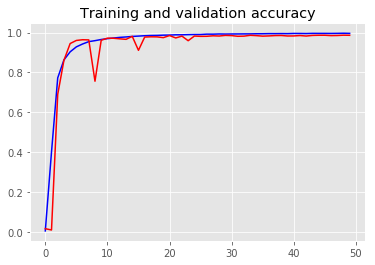

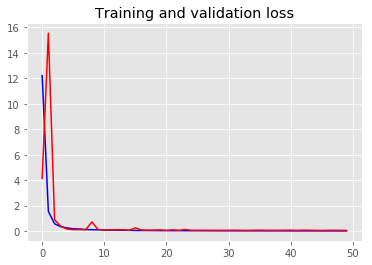

In [10]:
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

rootpath = 'G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/'

img_w, img_h = 128, 64
batch_size = 256
downsample_factor = 4
max_text_len = 12
num_classes = len(letters) + 1

model = get_model(img_w, img_h, num_classes, True)
plot_model(model, to_file='model.png', show_shapes=True)

try:
    model.load_weights('best_weight.hdf5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

data_train = TextImageGenerator(rootpath, X_train, y_train, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_train.build_data()
data_valid = TextImageGenerator(rootpath, X_valid, y_valid, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_valid.build_data()
data_test = TextImageGenerator(rootpath, X_test, y_test, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_test.build_data()

checkpoint = ModelCheckpoint(filepath='best_weight.hdf5', monitor='val_acc', verbose=0, save_best_only=True, period=1)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

history_ft = model.fit_generator(generator=data_train.next_batch(),
                    steps_per_epoch=int(data_train.n / batch_size),
                    epochs=50,
                    verbose = 2,
                    callbacks=[checkpoint],
                    validation_data=data_valid.next_batch(),
                    validation_steps=int(data_valid.n / batch_size))

plot_training(history_ft)

In [54]:
model.save('model_acc9964_valacc_9868.h5')

In [13]:
import itertools

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

model_best = get_model(img_w, img_h, num_classes, False)
model_best.load_weights("best_weight.hdf5")

total = 0
acc = 0
letter_total = 0
letter_acc = 0

for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model_best.predict(img_pred)
    pred_texts = decode_label(net_out_value)
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))

    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

10000it [03:47, 44.00it/s]


ACC :  0.9858
letter ACC :  0.9331849699667213


In [34]:
a = eval('4-8+1')
type(a)
import builtins
str = builtins.str
str(a)

'-3'

In [35]:
import string
import builtins
str = builtins.str
digits = string.digits
operators = '+-*'
def generate():
    seq = ''
    k = random.randint(0, 2)
    
    if k == 1:
        seq += '('
    seq += random.choice(digits)
    seq += random.choice(operators)
    if k == 2:
        seq += '('
    seq += random.choice(digits)
    if k == 1:
        seq += ')'
    seq += random.choice(operators)
    seq += random.choice(digits)
    if k == 2:
        seq += ')'
        
    return seq+'='+str(eval(seq))

generate()

'8+2*1=10'

In [67]:
from captcha.image import ImageCaptcha
def gen(img_h, img_w, max_text_len, downsample_factor, batch_size=32):
    X_data = np.ones([batch_size, img_w, img_h, 1])
    Y_data = np.empty([batch_size, max_text_len])
    input_length = np.ones((batch_size, 1)) * (img_w // downsample_factor - 2)
    label_length = np.zeros((batch_size, 1))
    generator = ImageCaptcha(width=300, height=64)
    while True:
        for i in range(batch_size):
            random_str = generate()
            image = generator.generate_image(random_str)
            img = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2GRAY)
            img = cv2.resize(img, (img_w, img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            img = img.T
            img = np.expand_dims(img, -1)
            img = np.expand_dims(img, axis=0)
            X_data[i] = img
            labels = text_to_labels(random_str)
            Y_data[i, 0:len(labels)] = labels
            Y_data[i, len(labels):13] = 16
            label_length[i] = len(random_str)
        inputs = {
            'the_input': X_data,
            'the_labels': Y_data,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc': np.zeros([batch_size])}
        yield (inputs, outputs)

Epoch 1/40
 - 352s - loss: 0.3557 - acc: 0.9489 - val_loss: 6.7798 - val_acc: 0.1726
Epoch 2/40
 - 343s - loss: 0.3181 - acc: 0.9572 - val_loss: 5.4615 - val_acc: 0.1831
Epoch 3/40
 - 342s - loss: 0.3136 - acc: 0.9607 - val_loss: 9.6416 - val_acc: 0.0576
Epoch 4/40
 - 345s - loss: 0.3004 - acc: 0.9634 - val_loss: 6.7854 - val_acc: 0.1232
Epoch 5/40
 - 343s - loss: 0.2864 - acc: 0.9661 - val_loss: 9.3759 - val_acc: 0.0556
Epoch 6/40
 - 341s - loss: 0.2830 - acc: 0.9698 - val_loss: 6.4628 - val_acc: 0.1220
Epoch 7/40
 - 340s - loss: 0.2792 - acc: 0.9708 - val_loss: 6.4122 - val_acc: 0.1420
Epoch 8/40
 - 341s - loss: 0.2668 - acc: 0.9725 - val_loss: 8.2104 - val_acc: 0.0942
Epoch 9/40
 - 341s - loss: 0.2740 - acc: 0.9734 - val_loss: 21.5839 - val_acc: 0.0018
Epoch 10/40
 - 341s - loss: 0.2739 - acc: 0.9747 - val_loss: 6.8370 - val_acc: 0.1498
Epoch 11/40
 - 341s - loss: 0.2678 - acc: 0.9750 - val_loss: 15.5438 - val_acc: 0.0169
Epoch 12/40
 - 341s - loss: 0.2416 - acc: 0.9762 - val_loss: 

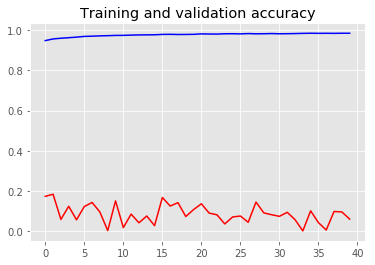

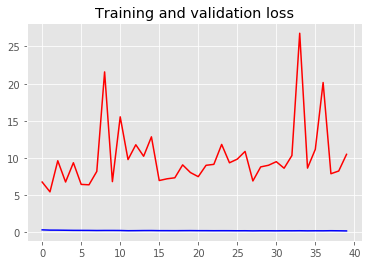

In [58]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

history_ft = model.fit_generator(generator=gen(img_h, img_w, max_text_len, downsample_factor, batch_size),
                    steps_per_epoch=int(data_train.n / batch_size),
                    epochs=40,
                    verbose = 2,
                    callbacks=[checkpoint],
                    validation_data=data_valid.next_batch(),
                    validation_steps=int(data_valid.n / batch_size))

plot_training(history_ft)

In [60]:
model.save('model_acc9855_valacc_0.0592.h5')

In [71]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

history_ft = model.fit_generator(generator=gen(img_h, img_w, max_text_len, downsample_factor, batch_size),
                    steps_per_epoch=int(data_train.n / batch_size),
                    epochs=5,
                    verbose = 2,
                    callbacks=[checkpoint],
                    validation_data=data_valid.next_batch(),
                    validation_steps=int(data_valid.n / batch_size))

plot_training(history_ft)

Epoch 1/5


KeyboardInterrupt: 

In [62]:

model_best1 = get_model(img_w, img_h, num_classes, False)
model_best1.load_weights("model_acc9855_valacc_0.0592.h5")

total = 0
acc = 0
letter_total = 0
letter_acc = 0

for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model_best1.predict(img_pred)
    pred_texts = decode_label(net_out_value)
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))

    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

10000it [03:46, 44.06it/s]


ACC :  0.1029
letter ACC :  0.6369859576219298


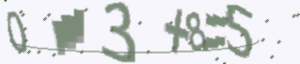

In [84]:
from IPython.display import display
import matplotlib.pyplot as plt
import imp
from captcha.image import ImageCaptcha
# imp.reload(captcha)
generator = ImageCaptcha(width=300, height=64)
img111 = generator.generate_image(generate())
display(img111)
# img111.

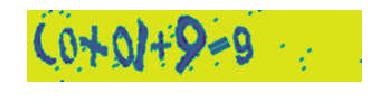

In [64]:
lenna_img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/0.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(lenna_img)
plt.axis("off")#去除坐标轴
plt.show()